# **BB84 Quantum Key Distribution Protocol**

## **Overview of Quantum Key Distribution (QKD)**
QKD allows two parties, often referred to as **Alice** and **Bob**, to securely exchange a secret key over a quantum communication channel (e.g., transmitting single photons). This process involves:
1. **Qubit Transmission** – The sender (Alice) encodes a secret key into qubits and transmits them.
2. **Measurement & Basis Selection** – The receiver (Bob) measures the qubits using randomly chosen bases.
3. **Key Sifting** – Alice and Bob discard measurements made in mismatched bases.
4. **Error Checking** – They compare a subset of bits to detect eavesdropping.
5. **Final Key Generation** – After removing errors and compromised bits, a secure key is established.

## **Key Exchange Process in Quantum Key Distribution**

### **Alice’s Key Preparation**
Alice randomly selects a basis (one of two possible bases) for each bit she wants to transmit. This results in two random bit strings on her side:
- One string represents her **choice of basis**.
- The other string represents the **actual bit values** she sends.

### **Bob’s Measurement Process**
Bob receives the quantum signals from Alice and randomly chooses one of the two bases to measure each incoming qubit. Due to the orthogonality of the quantum states within each of Alice’s bases, his measurements yield well-defined results when his chosen basis matches Alice’s.

As a result, Bob obtains:
1. A record of **which basis he used** for each measurement.
2. A corresponding **sequence of measured bit values**.

### **Basis Reconciliation**
After transmitting and measuring all qubits, Alice and Bob publicly communicate to compare their **chosen bases**—without revealing the actual bit values. They discard any bit positions where their bases did not match. The remaining bits, where their bases aligned, are used to form a **raw key**.

### **Error Detection and Eavesdropping Check**
If the transmission occurred in an ideal channel with no interference, Alice’s and Bob’s bit strings should match perfectly. However, errors may arise due to:
- **Physical noise** in the communication channel.
- **Eavesdropping attempts** by a third party (interceptor).

To detect such errors, Alice and Bob publicly reveal a random subset of their remaining bits and compare them. Based on the **Central Limit Theorem**, the error rate in the revealed bits provides a reliable estimate of the total error rate in the entire key. If the error exceeds a predefined threshold, they assume the presence of an eavesdropper, and the key exchange is aborted to prevent key compromise.

If the error rate is acceptable, they proceed with **error correction and privacy amplification** to distill a final secret key suitable for encryption.



This protocol works as takes after: at each step, the transmitting side sends one of the 
states from the non-orthogonal set, and the accepting side measures that, after extra trade 
of classical data between the parties, they ought to have bit strings that totally coordinate 
within the case of a perfect channel and no interceptor. Blunders in these lines can show 
both the defect of the channel and the activities of the spy. If the mistake surpasses a certain 
constrain, the operation of the protocol is hindered, something else authentic clients can 
extricate the completely mystery key from their bit strings.

The BB84 protocol uses two bases:

**+ Basis:**

$$|V\rangle = |0\rangle, \quad |P\rangle = |1\rangle$$

**× Basis:**

$$|A\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle), \quad |B\rangle = \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle)$$




At the state planning organize, Alice haphazardly chooses one of the required bases, and 
after that arbitrarily chooses a bit esteem: or 1, and in agreement with this choice sends one 
of four signals (Table 1):

**Table 1. Alice’s sending signals according to basis and bit value**

| Signal | Basis | Bit value |
|:------:|:-----:|:---------:|
|   V    |   +   |     0     |
|   P    |   +   |     1     |
|   A    |   ×   |     0     |
|   B    |   ×   |     1     |




This implementation is based on Ref. [1], which analyzes BB84, B92, and E91 quantum key distribution protocols.   


## **Code Implementation**

In [78]:
from classiq import *
import numpy as np

In [79]:
# Define the quantum function for BB84 protocol.
# This function simulates the quantum part of BB84:
# 1. Alice encodes her message into qubits using her randomly chosen bit values.
# 2. She selects a basis (Z or X) for each qubit and applies a Hadamard gate if the basis is X.
# 3. The qubits are "sent" to Bob (implicitly, as we simulate it on the same system).
# 4. Bob measures the qubits using his own randomly chosen bases, applying a Hadamard gate before measurement if his basis is X.

@qfunc
def bb84(message: CArray[CBool], alice_bases: CArray[CBool], bob_bases: CArray[CBool], qba: QArray[QBit]) -> None:
    """
    Implements the quantum part of BB84 protocol.
    """
    # Alice encodes her message - apply X gates for 1s
    repeat(message.len,
           lambda i:
           if_(message[i]==1,
               lambda: X(qba[i])
              )
          )
    
    # Alice selects bases - apply H gates for X-basis (1)
    repeat(alice_bases.len,
           lambda i:
           if_(alice_bases[i]==1,
               lambda: H(qba[i])
              )
          )
    
    # Transmission of qubits happens here...
    
    # Bob measures in his chosen bases - apply H gates for X-basis (1)
    repeat(bob_bases.len,
           lambda i:
           if_(bob_bases[i]==1,
               lambda: H(qba[i])
              )
          )


SIZE = 8
np.random.seed(3)
message = np.random.randint(0, 2, SIZE).tolist()
alice_bases = np.random.randint(0, 2, SIZE).tolist()
bob_bases = np.random.randint(0, 2, SIZE).tolist()

@qfunc
def main(qba: Output[QArray[QBit]]) -> None:
    """
    Implements the quantum part of BB84 protocol with SIZE no of qubits.
    """
    allocate(SIZE, qba)
    bb84(message, alice_bases, bob_bases, qba)


In [80]:
# ===============================
# Quantum Model Creation
# ===============================
# Create a quantum model from the main function
qmod = create_model(main, out_file="bb84_implementation")

In [81]:
# ===============================
# Set Execution Preferences
# ===============================
from classiq.execution import ExecutionPreferences

execution_preferences = ExecutionPreferences(
    num_shots=2048
)
qmod = set_execution_preferences(qmod, execution_preferences)

In [82]:
# ===============================
# Circuit Synthesis and Execution
# ===============================
# Synthesize the quantum circuit to an executable form
qprog = synthesize(qmod)

In [ ]:
# Visualize the generated quantum circuit
show(qprog)

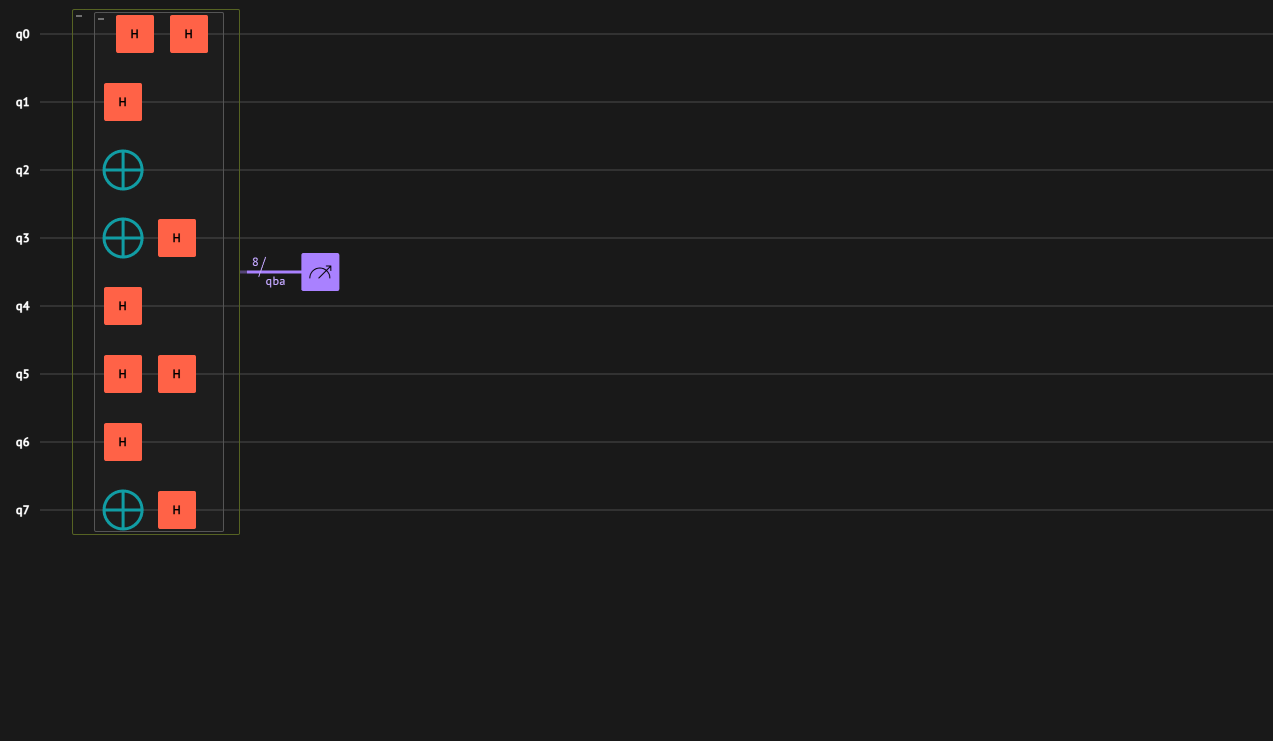

In [84]:
job = execute(qprog)

In [85]:
# ===============================
# Results Processing
# ===============================
# Fetch and print results from the quantum execution
print("Quantum Circuit Simulation:")
results = job.get_sample_result().parsed_counts

Quantum Circuit Simulation:


## **What Happens After the Measurement? (BB84 Explained)**
After Bob receives and measures the quantum bits (qubits), the BB84 protocol continues classically:

### **1. Basis Reconciliation**
Alice and Bob publicly share the bases they used to prepare and measure each qubit.

They then compare the bases for each position.

Bits where the bases match are kept; the rest are discarded.

### **2. Raw Key Extraction**
From the matched positions, Alice and Bob extract the raw key bits:

Alice uses her original message bits at those positions.

Bob uses his measurement results at those positions.

### **3. Error Estimation**
A small portion (typically ~25%) of the raw key is used to estimate the error rate.

If the error rate is low (e.g., <15%), they can assume no eavesdropping occurred.

### **4. Error Correction (Simulated Here)**
The remaining bits (after removing test bits) are treated as the corrected key.

In real QKD, error correction codes (like Cascade or LDPC) would be used.

### **5. Privacy Amplification**
To reduce an eavesdropper’s knowledge further, Alice and Bob apply a hash function.


In [ ]:
import numpy as np

def complete_bb84_protocol(measurements_list, alice_message=None, alice_bases=None, bob_bases=None):
    """
    Complete post-processing steps for the BB84 protocol.
    
    Args:
        measurements_list: List of classiq.interface.executor.result.SampledState objects
    """
    
    # 1. Define the known values
    if alice_message is None:
        alice_message = np.random.randint(0, 2, SIZE).tolist()
        print("Randomly generated alice_message:", alice_message)
    elif len(alice_message) != SIZE:
        raise ValueError(f"alice_message must have length {SIZE}")
    
    if alice_bases is None:
        alice_bases = np.random.randint(0, 2, SIZE).tolist()
        print("Randomly generated alice_bases:", alice_bases)

    if bob_bases is None:
        bob_bases = np.random.randint(0, 2, SIZE).tolist()
        print("Randomly generated bob_bases:", bob_bases)

    
    # 2. Extract Bob's measurement results from the measurement with highest shots
    try:
        # Find the measurement with the highest shot count
        highest_shots = -1
        highest_measurement = None
        
        for measurement in measurements_list:
            if measurement.shots > highest_shots:
                highest_shots = measurement.shots
                highest_measurement = measurement
        
        # Extract the qba array from the state attribute
        bob_measurements = highest_measurement.state['qba']
        
    except Exception as e:
        print(f"Error extracting measurements: {e}")
        # Fallback: try with the first measurement
        try:
            bob_measurements = measurements_list[0].state['qba']
        except Exception:
            raise ValueError("Could not extract measurement results from the SampledState objects")
    
    # Ensure we have valid measurements
    if not isinstance(bob_measurements, list) or len(bob_measurements) != SIZE:
        raise ValueError(f"Invalid measurement data: {bob_measurements}. Expected a list of SIZE no of bits.")
    
    print("\n=== BB84 Protocol Steps ===")
    print("1. QUANTUM PHASE (Already completed)")
    print("   - Alice prepared qubits in state corresponding to:", alice_message)
    print("   - Alice encoded using bases (0=Z, 1=X):", alice_bases)
    print("   - Bob measured using bases (0=Z, 1=X):", bob_bases)
    print("   - Bob's measurement results:", bob_measurements)
    
    # 3. BASIS RECONCILIATION PHASE
    print("\n2. BASIS RECONCILIATION (Public classical channel)")
    print("   - Alice announces: 'I used bases", alice_bases, "'")
    print("   - Bob announces: 'I used bases", bob_bases, "'")
    
    # 4. RAW KEY EXTRACTION
    matching_positions = []
    for i in range(len(alice_bases)):
        if alice_bases[i] == bob_bases[i]:
            matching_positions.append(i)
    
    print("\n3. RAW KEY EXTRACTION")
    print("   - Positions where bases match:", matching_positions)
    
    # Calculate Alice's raw key (what she expects)
    alice_raw_key = [alice_message[i] for i in matching_positions]
    
    # Calculate Bob's raw key (what he measured)
    bob_raw_key = [bob_measurements[i] for i in matching_positions]
    
    print("   - Alice's raw key:", alice_raw_key)
    print("   - Bob's raw key:", bob_raw_key)
    
     # 5. ERROR ESTIMATION
    if matching_positions:
        errors = sum(alice_message[pos] != bob_measurements[pos] for pos in matching_positions)
        error_rate = errors / len(matching_positions)
        
        print("\n4. ERROR ESTIMATION")
        print("   - Total matching positions:", len(matching_positions))
        print("   - Errors detected:", errors)
        print(f"   - Error rate: {error_rate:.2%}")
        
        # 6. ERROR CORRECTION
        # Only proceed if error rate is below threshold
        if error_rate < 0.15:  # Threshold for security
            print("\n5. ERROR CORRECTION")
            print("   - Error rate acceptable, proceeding with error correction")
            
            corrected_positions = [pos for pos in matching_positions if alice_message[pos] == bob_measurements[pos]]
            corrected_key = [alice_message[pos] for pos in corrected_positions]
            
            print("   - Positions used for final key:", corrected_positions)
            print("   - Corrected key:", corrected_key)
            
            # 7. PRIVACY AMPLIFICATION
            final_key = None
            if corrected_key and len(corrected_key) >= 2:
                print("\n6. PRIVACY AMPLIFICATION")
                
                # We are not using a cryptographic hash function like SHA-256 or MD5. 
                # Instead, We are performing a simple parity-based privacy amplification using the bitwise XOR (^) operation between pairs of bits from the corrected key.
                print("   - Applying hash function to reduce eavesdropper's information")
                final_key = []
                for i in range(0, len(corrected_key)-1, 2):
                    final_key.append(corrected_key[i] ^ corrected_key[i+1])
                
                print("   - Final secure key:", final_key)
            else:
                print("\n6. PRIVACY AMPLIFICATION")
                print("   - Not enough bits for privacy amplification after error correction")
                final_key = []
        else:
            print("\n5. PROTOCOL ABORT")
            print("   - Error rate too high, possible eavesdropper detected")
            print("   - Protocol aborted for security reasons")
            corrected_key = []
            final_key = None
    else:
        print("\nNo matching bases found - cannot proceed with key generation")
        error_rate = 1.0
        corrected_key = []
        final_key = None
    
    return {
        "alice_raw_key": alice_raw_key if 'alice_raw_key' in locals() else [],
        "bob_raw_key": bob_raw_key if 'bob_raw_key' in locals() else [],
        "error_rate": error_rate if 'error_rate' in locals() else 1.0,
        "final_key": final_key
    }


In [92]:
# ===============================
# Run the complete BB84 protocol
# ===============================

bb84_results = complete_bb84_protocol(list(results))

print("\nFinal Results Summary:")
print(bb84_results)

Randomly generated alice_message: [0, 0, 0, 1, 1, 0, 0, 0]
Randomly generated alice_bases: [1, 0, 1, 1, 1, 0, 0, 1]
Randomly generated bob_bases: [0, 1, 0, 1, 1, 0, 0, 1]

=== BB84 Protocol Steps ===
1. QUANTUM PHASE (Already completed)
   - Alice prepared qubits in state corresponding to: [0, 0, 0, 1, 1, 0, 0, 0]
   - Alice encoded using bases (0=Z, 1=X): [1, 0, 1, 1, 1, 0, 0, 1]
   - Bob measured using bases (0=Z, 1=X): [0, 1, 0, 1, 1, 0, 0, 1]
   - Bob's measurement results: [0, 1, 1, 1, 1, 0, 0, 0]

2. BASIS RECONCILIATION (Public classical channel)
   - Alice announces: 'I used bases [1, 0, 1, 1, 1, 0, 0, 1] '
   - Bob announces: 'I used bases [0, 1, 0, 1, 1, 0, 0, 1] '

3. RAW KEY EXTRACTION
   - Positions where bases match: [3, 4, 5, 6, 7]
   - Alice's raw key: [1, 1, 0, 0, 0]
   - Bob's raw key: [1, 1, 0, 0, 0]

4. ERROR ESTIMATION
   - Total matching positions: 5
   - Errors detected: 0
   - Error rate: 0.00%

5. ERROR CORRECTION
   - Error rate acceptable, proceeding with err

## **References**

**Note:** References [2]–[6] were not directly used in the implementation but provide valuable background and foundational knowledge on quantum cryptography and key distribution.

[1]: RESEARCH OF QUANTUM KEY DISTRIBUTION PROTOCOLS: BB84, B92, E91 
https://www.researchgate.net/publication/364588237_RESEARCH_OF_QUANTUM_KEY_DISTRIBUTION_PROTOCOLS_BB84_B92_E91

[2] C. H. Bennett and G. Brassard, "Quantum cryptography: Public key distribution and coin tossing," *Proceedings of IEEE International Conference on Computers, Systems and Signal Processing*, Bangalore, India, 1984.

[3] M. Nielsen and I. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press, 2000.

[4] N. Gisin, G. Ribordy, W. Tittel, and H. Zbinden, "Quantum cryptography," *Rev. Mod. Phys.*, vol. 74, no. 1, pp. 145-195, 2002.

[5] V. Scarani, H. Bechmann-Pasquinucci, N. J. Cerf, et al., "The security of practical quantum key distribution," *Rev. Mod. Phys.*, vol. 81, no. 3, pp. 1301-1350, 2009.

[6] S. Pirandola, U. L. Andersen, L. Banchi, et al., "Advances in quantum cryptography," *Advances in Optics and Photonics*, vol. 12, no. 4, pp. 1012-1236, 2020.